# Demo 07 - Benford's Law

This is a demo of Benford's Law.  Benford's Law is an interesting numerical phenomenon relating to the first digit in a sequence of numbers.

In [2]:
if(!require(tidyverse)) {
    install.packages("tidyverse", repos = "http://cran.us.r-project.org")
    library(tidyverse)
}

if(!require(benford.analysis)) {
    install.packages("benford.analysis", repos = "http://cran.us.r-project.org")
    library(benford.analysis)
}

if(!require(MASS)) {
    install.packages("MASS", repos = "http://cran.us.r-project.org")
    library(MASS)
}

if(!require(odbc)) {
    install.packages("odbc", repos = "http://cran.us.r-project.org")
    library(odbc)
}

First, we will manually build the first-digit Benford data set.  I am adding 0.5 to each value to make it easier to see the point against the histogram backdrop.

In [3]:
benford.predictions <- data.frame(
  c(1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5),
  c(0.301,0.176,0.125,0.097,0.079,0.067,0.058,0.051,0.046)
)
names(benford.predictions)[1] <- "Digit"
names(benford.predictions)[2] <- "Frequency"

The following function strips out the first digit, as we only care about the first digit for our analysis.

In [4]:
firstdigit <- function(k) {
  as.numeric(head(strsplit(as.character(k), '')[[1]],n=1))
}

## North Carolina Population

For our first example, we will load the North Carolina population as of 2013.

In [5]:
nc.pop <- read.csv("Data/NorthCarolinaPopulation2013.csv", sep=",", header=TRUE)

In [6]:
tail(nc.pop, 5)

,City,Counties,Population
548,Winston-Salem,FORSYTH,238899
549,Durham,DURHAM/ORANGE/WAKE,250931
550,Greensboro,GUILFORD,282840
551,Raleigh,WAKE/DURHAM,440621
552,Charlotte,MECKLENBURG,818480


Now we will take the population data and get just the first digit.  We will build a histogram of the first digit of each city's population, and then overlay that with what our Benford analysis values would predict.

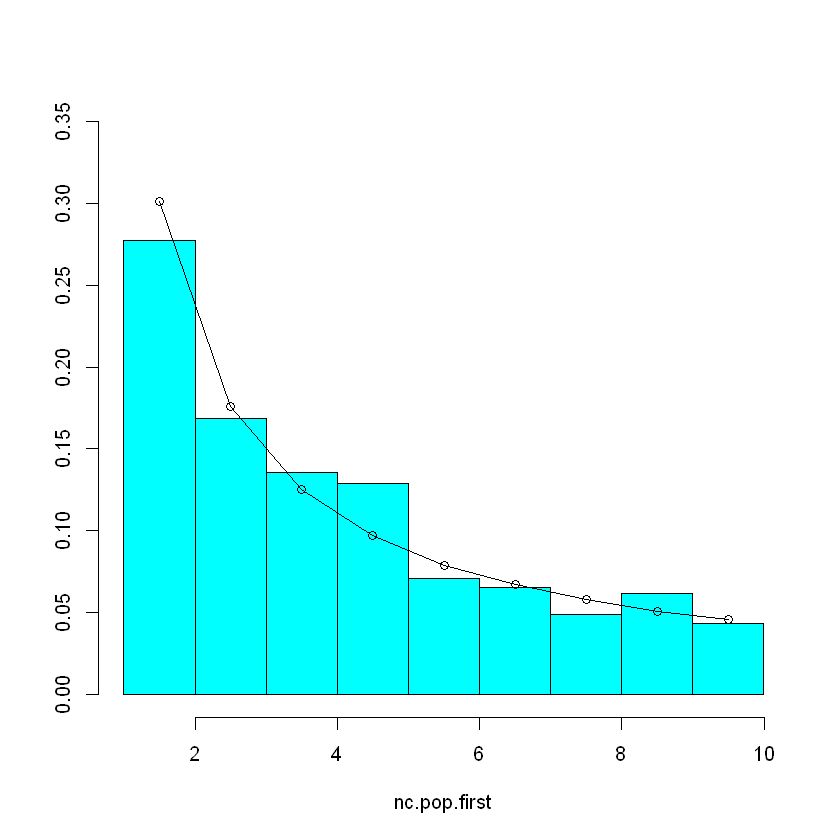

In [7]:
nc.pop.first <- sapply(nc.pop$Population, firstdigit)
truehist(nc.pop.first, nbins=10, ymax = 0.35)
points(benford.predictions)
lines(benford.predictions)

It's not perfect, but it certainly fits.

Now let's look at a fancier method of plotting Benford analysis, using the benford.analysis library that we loaded at the top of the notebook.

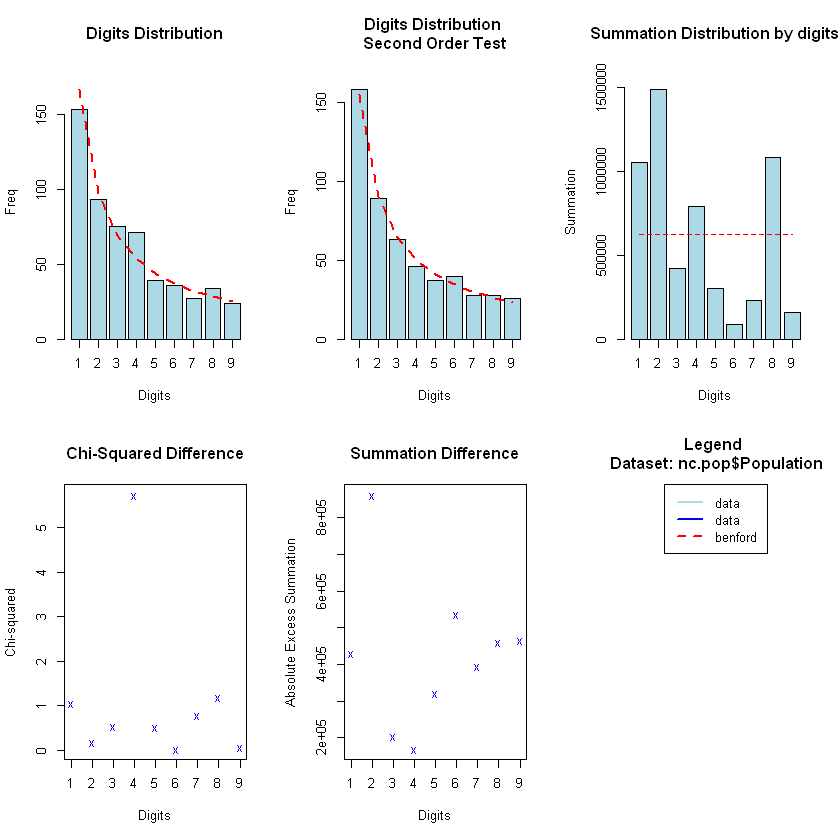

In [8]:
cp <- benford(data = nc.pop$Population, number.of.digits = 1, sign = "positive", discrete=TRUE, round=3)
plot(cp)

Following from the Benford analysis tutorial (https://github.com/carloscinelli/benford.analysis), we should expect values similar to the following when looking at the results:

|statistic|values|
|---------|------|
|mean|0.5|
|variance|0.0833 (1/12)|
|kurtosis|-1.2|
|skewness|0|


In [9]:
cp$mantissa

statistic,values
Mean Mantissa,0.50999050
Var Mantissa,0.07991550
Ex. Kurtosis Mantissa,-1.14403826
Skewness Mantissa,-0.05238512


Our actual results are very close to the expected results.

### Two-Digit Sampling

Now let's try two-digit sampling.  Instead of looking at just the first digit of each number, let's look at the first two digits.  Benford's Law has a set of predictions for each two-digit pairing.

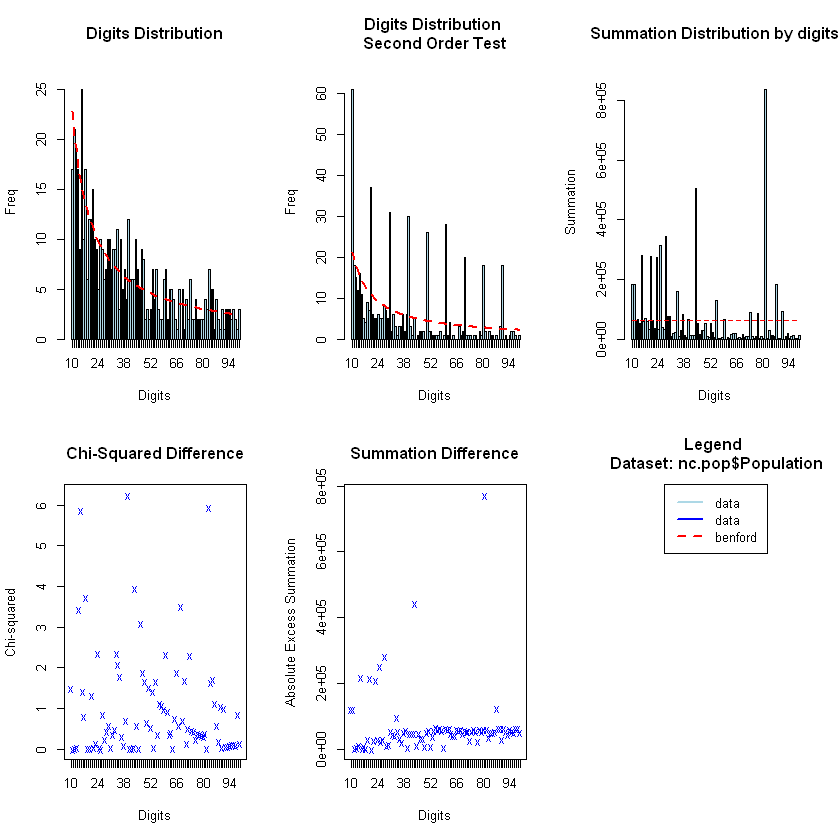

In [10]:
cp2 <- benford(data = nc.pop$Population, number.of.digits = 2, sign = "positive", discrete=TRUE, round=3)
plot(cp2)

Note:  the spikes in the second-order test does *not* indicate a problem; it indicates that the data is discrete, not continuous.  This is a common occurrence with discrete values packed into tight ranges.

## Expenses Data

Our second example looks at the data set we've used throughout this talk.

In [11]:
conn <- DBI::dbConnect(odbc::odbc(), 
                      Driver = "SQL Server", 
                      Server = "localhost", 
                      Database = "ForensicAccounting", 
                      Trusted_Connection = "True")

In [12]:
lineItems <- DBI::dbGetQuery(conn, "SELECT
	li.LineItemDate,
	c.CalendarMonth,
	c.MonthName,
	c.CalendarYear,
	c.FirstDayOfMonth,
	li.Amount
FROM dbo.LineItem li
	INNER JOIN dbo.Calendar c
		ON li.LineItemDate = c.Date;
")
lineItems$FirstDayOfMonth <- lubridate::ymd(lineItems$FirstDayOfMonth)

First we want to get the amount of each line item and contrast it with what Benford's Law suggests we should have.

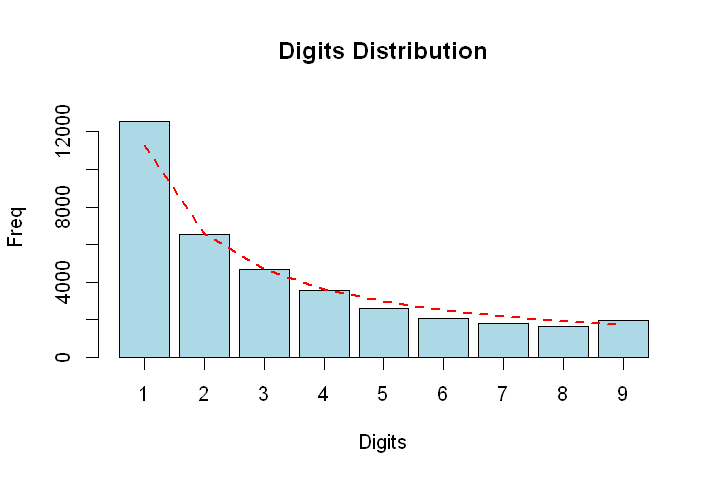

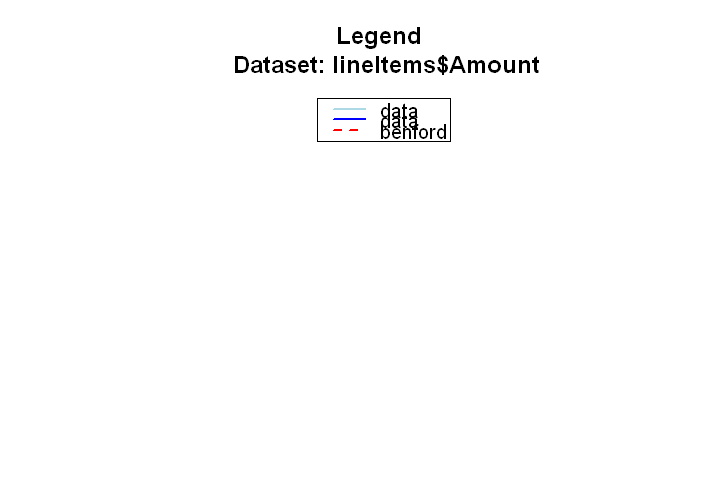

In [13]:
options(repr.plot.width=6, repr.plot.height=4)
cp <- benford(data = lineItems$Amount, number.of.digits = 1, sign = "positive", discrete=TRUE, round=3)
plot(cp, except=c("second order", "summation", "mantissa", "chi squared", "abs diff", "ex summation", "legend"))

In [14]:
cp$mantissa

statistic,values
Mean Mantissa,0.48296962
Var Mantissa,0.08213391
Ex. Kurtosis Mantissa,-1.16179515
Skewness Mantissa,0.14383138


All in all, this is a **really** good fit.  Remember that our ideals are:

|statistic|values|
|---------|------|
|mean|0.5|
|variance|0.0833 (1/12)|
|kurtosis|-1.2|
|skewness|0|

Let's see how it looks prior to 2018.

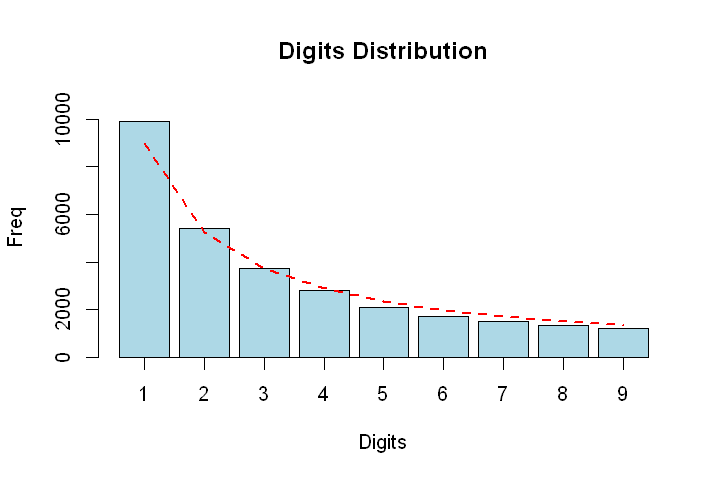

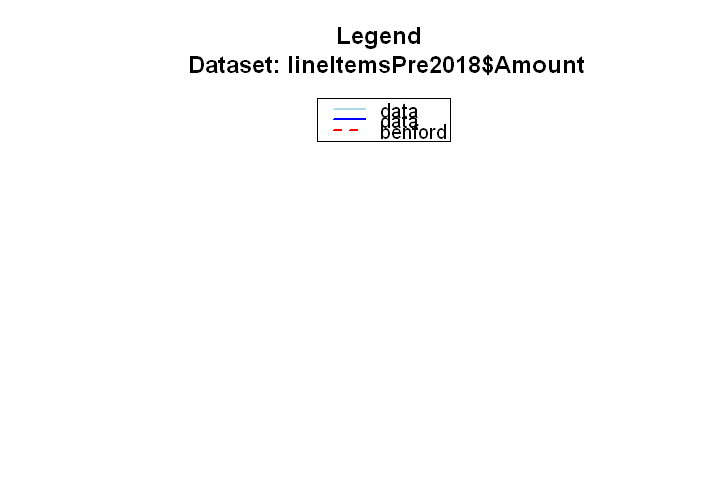

In [15]:
options(repr.plot.width=6, repr.plot.height=4)
lineItemsPre2018 <- lineItems %>% filter(CalendarYear < 2018)
cp <- benford(data = lineItemsPre2018$Amount, number.of.digits = 1, sign = "positive", discrete=TRUE, round=3)
plot(cp, except=c("second order", "summation", "mantissa", "chi squared", "abs diff", "ex summation", "legend"))

In [16]:
cp$mantissa

statistic,values
Mean Mantissa,0.47921968
Var Mantissa,0.08005563
Ex. Kurtosis Mantissa,-1.15415494
Skewness Mantissa,0.13319884


This is a tiny bit worse than the ideal.  So how does 2018 look?

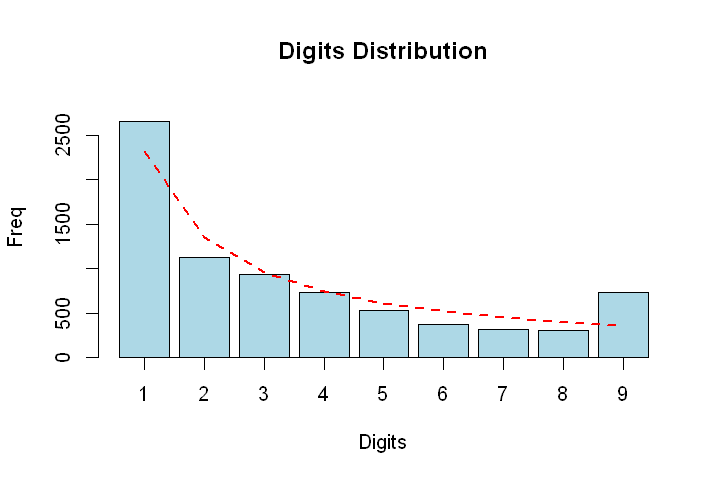

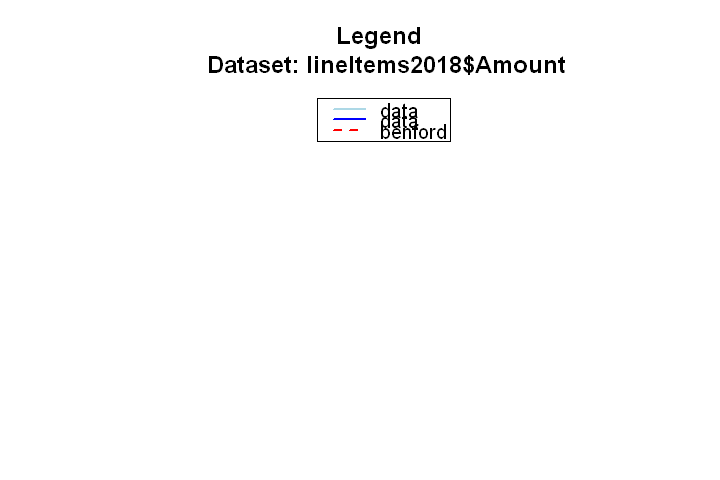

In [17]:
options(repr.plot.width=6, repr.plot.height=4)
lineItems2018 <- lineItems %>% filter(CalendarYear == 2018)
cp <- benford(data = lineItems2018$Amount, number.of.digits = 1, sign = "positive", discrete=TRUE, round=3)
plot(cp, except=c("second order", "summation", "mantissa", "chi squared", "abs diff", "ex summation", "legend"))

In [18]:
cp$mantissa

statistic,values
Mean Mantissa,0.49746433
Var Mantissa,0.08991409
Ex. Kurtosis Mantissa,-1.21989019
Skewness Mantissa,0.16244442


Even with the crazy skew around amount starting with the number 9, our mantissa comes close to ideal.

## Last Digit Analysis

Now that we see Benford's Law holding for North Carolina's population and our expenditure analysis, does the same phenomenon hold for the *last* digit of each number?

To figure this out, we first need to create a function to get the last digit of each number.

In [19]:
lastdigit <- function(k) {
  as.numeric(tail(strsplit(as.character(k), '')[[1]],n=1))
}

Next up, we will apply the function to each record in nc.pop, build a histogram, and overlay the Benford predictions.

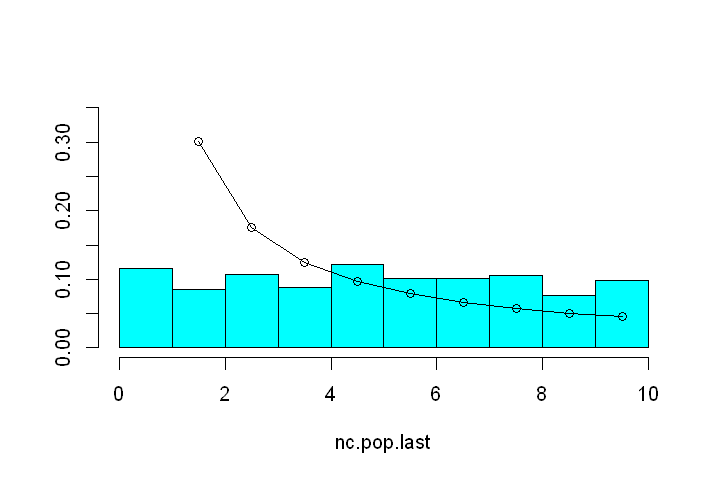

In [20]:
nc.pop.last <- sapply(nc.pop$Population, lastdigit)
truehist(nc.pop.last, nbins=10, ymax = 0.35)
points(benford.predictions)
lines(benford.predictions)

Benford's Law emphatically does not fit here.  Furthermore, last digits are *not* expected to follow Benford's Law.  Instead, we should assume that the last digit is uniform unless there is a reason to believe otherwise.

Similarly, here is the last digit for the fraud data set:

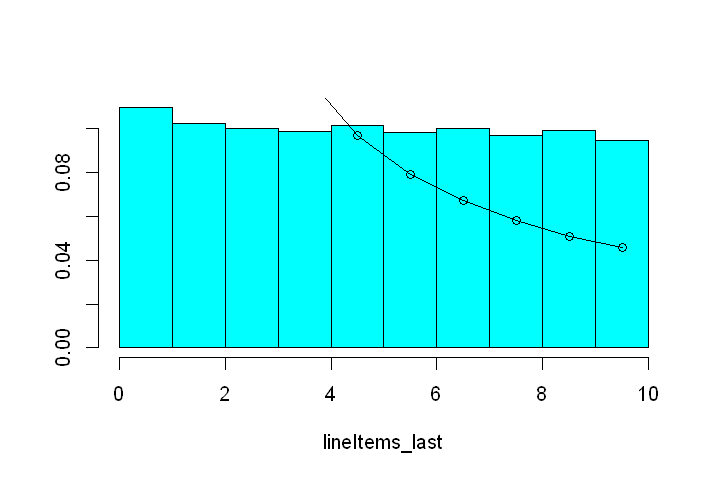

In [21]:
options(repr.plot.width=6, repr.plot.height=4)
lineItems_last <- sapply(round(lineItems$Amount), lastdigit)
truehist(lineItems_last, nbins=10)
points(benford.predictions)
lines(benford.predictions)

Benford's Law applies to first digits, not last digits.  Instead, we usually assume uniformity with last digits unless there is a reason to believe otherwise.  One reason to believe otherwise is budgets:  we tend to see budgets end with 0 much more frequently than other numbers because budgets are estimations and people tend to avoid false precision with those sorts of estimations.